# Computing Necessairy Secretion Rate
In this notebook, we will derive the necessairy production rate of different inhibitors in a probiotic bacteria for that probiotic bacteria to be able to affect the Curli formation in a medium with $10^9\frac{mol}{dm^3}$ Curli-producing bacteria and $10^9\frac{mol}{dm^3}$ inhibitor producing, probiotic bacteria. To reduce the amount of code in this notebook, we have implemented the Curli fibril formation described in "this" notebook, into a single class. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import N_A
from IPython.display import display, Math, Latex
from fibrilformation import UniformFibrilFormation, CurliFibril
from numericaldiffusion import Inhibitor
print('Documentation UniformFibrilFormation')
print(UniformFibrilFormation.__doc__)
print('UniformFibrilFormation __init__ function')
print(UniformFibrilFormation.__init__.__doc__)
print('Inhibitors')
print(Inhibitor.__init__.__doc__)

Documentation UniformFibrilFormation

    Simulates Curli fibril formation given environment and inhibitors.

    ...

    Attributes
    ----------
    dist: float
        total simulated distance from bacteria cell membrane
    CSGBRATE: constant 1.3e-13
        production rate of CsgB protein (nbr/bacteria/s)
    xsteps: int
        number of bins to keep track of fibrils in
    deltat: float
        length of one timestep
    deltax: float
        length of one bin
    cBacteria: float
        bacteria concentration

    Methods
    ----------
    timeStep:
        Steps time forward one timestep
        Args:
            None
        Returns:
            None
    getTime:
        Returns the total time simulated this far
        Args:
            None
        Returns:
            total time (float)
    getMass:
        Returns the total mass of Curli fibrils (/CsgA mass)
        Args:
            None
        Returns:
            total mass (int)
    getMassProfile:
        Return

In [2]:
MAX_DISTANCE = 2e-5 #m
N_XSTEPS = 500
x_step_length = MAX_DISTANCE / N_XSTEPS
TIME_STEP_LENGTH = 5 #s
TOTAL_TIME = 5*3600 #s
C_BACTERIA = 1e12 #bac / dm3

display(Latex(f'Maximum distance from cell: ${MAX_DISTANCE *1e6}\mu m$'))
display(Latex(f'Length of one xBin: ${x_step_length*1e6}\mu m$'))
display(Latex(f'Total simulated time: ${TOTAL_TIME /3600} hours$'))
display(Latex(f'Length of one timestep: ${TIME_STEP_LENGTH}s$'))
display(Latex(f'Bacteria concentration: $10^{int(np.log10(C_BACTERIA))} bac/dm^3$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

We can now start defining our inhibitors. We have already done this for QFG(link) but it can be done in a similar fashion for CsgC.Inheriting from the previously constructed Inhibitor class gives the object some increased flexibility.

In [3]:
class QFG(Inhibitor):
    """The inhibitor binding to CsgA. 
    The binding constant Ka was estimated by assuming first order binding to the CsgA monomers \
        and then computing the equilibrium constant from previous published results. 
    """
    Ka = 0.2
    name = 'QFG'
    def __init__(self, pinh):
        super().__init__(MAX_DISTANCE, N_XSTEPS, TIME_STEP_LENGTH, pinh, cBacteria=C_BACTERIA)

    def bindingFunc(self, monC):
        """The function declaring how the inhibitor will affect the CsgA concentration. \
            The function edits the concentration inplace. 
            Note that the function only is implemented for uniform concentrations. 

        Args:
            monC (CsgADiffusion): An object describing the CsgA monomers.
        """
        if self.how == 'uniform' and monC.how == 'uniform':
            self.c -= max(self.Ka*self.c*monC.c*self.deltat,0)
            monC.c -= max(self.Ka*self.c*monC.c*self.deltat,0)

class CsgC(Inhibitor):
    """The CsgC chaperone. The function for rate inhibition was derived in a seperate notebook.
    """
    name = 'CsgC'
    
    def R(self,r):
        C1 = 163
        C2 = -213
        return  1/(1+C1*r)**3*(2+C2*r)/(2+2*C2*r+2*C2**2*r**2)
    
    def __init__(self, pinh):
        super().__init__(MAX_DISTANCE, N_XSTEPS, TIME_STEP_LENGTH, pinh, cBacteria=C_BACTERIA)
    
    def rateFunc(self, monC, kwrates):
        """A function describing the affect the CsgC concentration will have on the reaction rates.\
            Values computed by fitting an exponential function to previously published data. 
            The CsgC is assumed to not degrade or diffuse away. -_('H')_-


        Args:
            monC (CsgADiffusion): The monomer concentration at the given timeHas no affect on the CsgC 
            kwrates (dict<string, float>): Rate constants in a dictionary

        Returns:
            dict<string,float>: New rate constants
        """
        kwrates['kplus'] = np.sqrt(max(5/3*self.R(self.c/max(monC.c,1e-16)), 0))*kwrates['kplus']
        return kwrates



The constant $pinh$ is the inhibitor production rate for the probiotic bacteria. Let's define "<i> a significant decrease in Curli formation</i>" as a decrease to 50% of the original Curli fibril formation. We can now, similarly to how we derived the reaction rate of the QFG inhibitor, find the necessairy production rate of each of the inhibitors. 

Running 3600 timesteps of 5 s


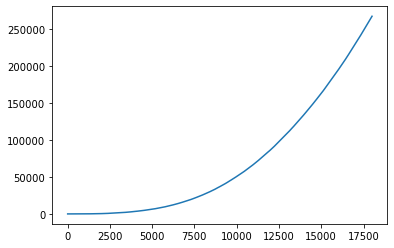

In [4]:
from time import time

def simulate_fibrilation(pinh, inhibitor):
    n_time_steps = int(TOTAL_TIME / TIME_STEP_LENGTH)
    inh = inhibitor(pinh)
    
    
    model = UniformFibrilFormation(MAX_DISTANCE, N_XSTEPS, TIME_STEP_LENGTH, inhibitors=[inh], cBacteria=C_BACTERIA)

    total_mass_list = []
    time_list = []
    print(f'Running {n_time_steps} timesteps of {TIME_STEP_LENGTH} s')
    for t in range(n_time_steps):
        model.timeStep()
        total_mass_list.append(model.getMass())
        time_list.append(model.getTime())
    return model, time_list, total_mass_list

_, time_list, total_mass_list = simulate_fibrilation(0, QFG)
plt.plot(time_list, total_mass_list)
plt.show()
fit_mass = total_mass_list[-1] * 0.5

pinh = 1e-08
Running 3600 timesteps of 5 s
Finished in 1.3919389247894287s, Total mass: 0, error: 1.0

pinh = 1e-12
Running 3600 timesteps of 5 s
Finished in 1.3237125873565674s, Total mass: 0, error: 1.0

pinh = 1e-14
Running 3600 timesteps of 5 s
Finished in 10.407943964004517s, Total mass: 318478, error: 1.3810371123538383

pinh = 1e-13
Running 3600 timesteps of 5 s
Finished in 10.844172477722168s, Total mass: 271797, error: 1.0320359460510184

pinh = 3.162277660168379e-13
Running 3600 timesteps of 5 s
Finished in 6.0853705406188965s, Total mass: 169506, error: 0.2672777295971769

pinh = 5.62341325190349e-13
Running 3600 timesteps of 5 s
Finished in 3.864739418029785s, Total mass: 79220, error: 0.4077275038129131

pinh = 4.216965034285822e-13
Running 3600 timesteps of 5 s
Finished in 5.244301080703735s, Total mass: 122961, error: 0.08070665988815451

pinh = 3.651741272548377e-13
Running 3600 timesteps of 5 s
Finished in 6.2509777545928955s, Total mass: 141886, error: 0.0607823200454

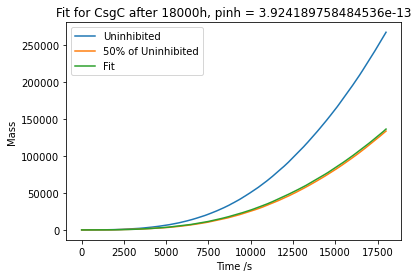

pinh = 1e-08
Running 3600 timesteps of 5 s
Finished in 7.8969032764434814s, Total mass: 241189, error: 0.8032013517150633

pinh = 0.0001
Running 3600 timesteps of 5 s
Finished in 1.3589308261871338s, Total mass: 29, error: 0.9997831872962708

pinh = 1e-06
Running 3600 timesteps of 5 s
Finished in 1.9749939441680908s, Total mass: 13836, error: 0.8965579114207961

pinh = 1e-07
Running 3600 timesteps of 5 s
Finished in 4.567013740539551s, Total mass: 109307, error: 0.18278806184395469

pinh = 3.162277660168379e-08
Running 3600 timesteps of 5 s
Finished in 6.303477048873901s, Total mass: 194664, error: 0.45536648823230363

pinh = 5.6234132519034905e-08
Running 3600 timesteps of 5 s
Finished in 5.922983169555664s, Total mass: 150714, error: 0.1267830975806692

pinh = 7.498942093324557e-08
Running 3600 timesteps of 5 s
Finished in 6.750231027603149s, Total mass: 132924, error: 0.0062202817069888505

##################DONE#############
pinh = 7.498942093324557e-08
Error: 0.0062202817069888505

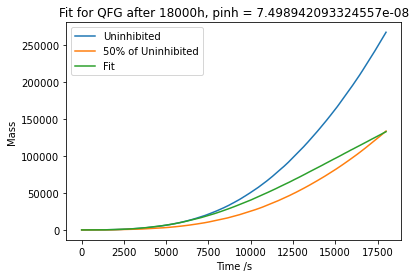

Fitted pinh: [3.924189758484536e-13, 7.498942093324557e-08]


In [5]:
def binary_search(inhibitor, lower_bound=1e-16, upper_bound=1):
    max_iter = 10 
    while max_iter > 0:
        timer1 = time()
        pinh = np.sqrt(upper_bound*lower_bound)
        print(f'pinh = {pinh}')
        _, ttime_list, ttotal_mass_list = simulate_fibrilation(pinh, inhibitor)
        estimated_mass = ttotal_mass_list[-1]

        if estimated_mass >= fit_mass:
            lower_bound = pinh
        else:
            upper_bound = pinh
        max_iter -= 1
        print(f'Finished in {time() - timer1}s, Total mass: {estimated_mass}, error: {abs(estimated_mass /fit_mass -1)}\n')
        if abs(estimated_mass / fit_mass - 1) < 0.05:
            print('##################DONE#############')
            print(f'pinh = {pinh}')
            print(f'Error: {abs(estimated_mass / fit_mass - 1)}')
            break
        
    return pinh, ttime_list, ttotal_mass_list
    
all_fitted_pinh = []
inhibitors = [CsgC, QFG]

for inhibitor in inhibitors:
    timer = time()
    
    pinh, time_list_fitted, total_mass_list_fitted = binary_search(inhibitor)
    all_fitted_pinh.append(pinh)
    print(f'T = {TOTAL_TIME} h done in {time() - timer}s \n')
    plt.plot(time_list, total_mass_list, label='Uninhibited')
    plt.plot(time_list, [0.5*x for x in total_mass_list], label='50% of Uninhibited')
    plt.plot(time_list_fitted, total_mass_list_fitted, label='Fit')
    plt.xlabel('Time /s')
    plt.ylabel('Mass')
    plt.legend()
    plt.title(f'Fit for {inhibitor.name} after {TOTAL_TIME}h, pinh = {pinh}')
    plt.show()

print(f"Fitted pinh: {all_fitted_pinh}")
    
    

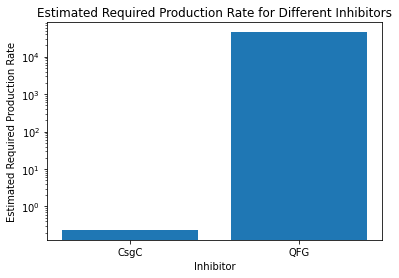

In [7]:
plt.bar([inh.name for inh in inhibitors], np.array(all_fitted_pinh)*N_A/C_BACTERIA)
plt.xlabel('Inhibitor')
plt.ylabel('Estimated Required Production Rate')
plt.title('Estimated Required Production Rate for Different Inhibitors')
plt.yscale('log')
plt.savefig('../figures/ProductionRateComparison.png')
plt.show()